# Lineaarinen ja logistinen regressio

## Tavoitteet
Tavoitteena on ennustaa talon hintaa per neliömetri New Taipei City, Taiwanissa. Käytämme mallinnuksessa lineaarista ja logistista regressiota. Tutkimme datasetistä löytyviä talojen arvoja ja käytämmä näitä koneoppimismallien kouluttamiseen ja testaamiseen.


In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd

# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)
# data (as pandas dataframes)
X = real_estate_valuation.data.features
y = real_estate_valuation.data.targets
# metadata
print(real_estate_valuation.metadata)
# variable information
print(real_estate_valuation.variables)

{'uci_id': 477, 'name': 'Real Estate Valuation', 'repository_url': 'https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set', 'data_url': 'https://archive.ics.uci.edu/static/public/477/data.csv', 'abstract': 'The real estate valuation is a regression problem. The market historical data set of real estate valuation are collected from Sindian Dist., New Taipei City, Taiwan. ', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 414, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Y house price of unit area'], 'index_col': ['No'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C5J30W', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'title': 'Building real estate valuation models with comparative approach through case-based reasoning', 'authors': 'I. Yeh, Tzu-Kuang Hsu', 'published_

In [2]:
X.describe(include="all")

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270


## Datan kuvaus
Datasetti pitää sisällään erilaisia tietoja taloista Taiwanissa. Datasetti sisältää seuraavat sarakkeet:
- X1 transaction date: Talon myynnin päivämäärä
- X2 house age: Talon ikä
- X3 distance to the nearest MRT station: Etäisyys lähimpään metroasemaan
- X4 number of convenience stores: Lähellä olevien ruokakauppojen määrä
- X5 latitude: Talon leveysaste
- X6 longitude: Talon pituusaste

Näillä arvoilla tavoitteenamme on ennustaa talon hintaa per ping. Tulos-sarakkeen arvot ovat 10000 New Taiwan Dollaria/Ping. 1 ping = 3,3 neliömetriä.


## Datan esikäsittely
Datasetti pitää jakaa testi- ja koulutusdataan.
Datasetti sisältää omnia eri-kokoisia arvoja, joten skaalaamme datasetin ennen mallinnusta. Käytämme StandardScaleria, joka skaalaa arvot keskihajonnan ja keskiarvon mukaan. Tämä on tärkeää, koska lineaarinen ja logistinen regressio ovat herkkiä eri-kokoisille arvoille.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_train

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,0.001128,2.344015,-0.823965,0.968042,-0.147066,0.455057
1,0.296351,-0.821281,0.951418,-0.049170,-0.743117,-1.355926
2,-1.777321,-0.900856,0.917224,-0.388241,-0.504055,-1.427483
3,-0.297651,1.707419,-0.469361,1.307112,0.065523,0.739277
4,0.890353,-0.865489,-0.345357,0.289900,0.260463,0.953278
...,...,...,...,...,...,...
326,-0.297651,1.610161,-0.344436,-0.388241,0.505141,0.218319
327,-0.297651,-0.007853,-0.715479,1.307112,0.620661,0.614889
328,0.591573,-0.573716,-0.663621,-1.066382,0.422512,-0.229077
329,-1.186876,-1.121896,-0.657800,0.628971,0.522789,0.753990


## Mallinnus
Mallinnamme nyt skaalattua dataa lineaarisen ja logistisen regressiomallin avulla. 

### Lineaarien regressio

In [5]:
# linear regression
from sklearn.linear_model import LinearRegression

lin = LinearRegression().fit(X_train, y_train)
beta0 = lin.intercept_
beta1 = lin.coef_
print("beta0:", + beta0)
print("beta1:", + beta1)

beta0: [38.39154079]
beta1: [[ 1.52963113 -3.06269441 -5.78692561  3.2188727   2.85510785 -0.4410086 ]]


Piirrämme kaikki arvojen kertoimet graafiin, mikä helpottaa tietojen hahmotusta. Sarakkeiden kerroin arvon on asetettu x-rivitekstin loppuun sulkeiden sisälle. Yritämme löytää graafeista suurin kertoimen itseisarvoa.

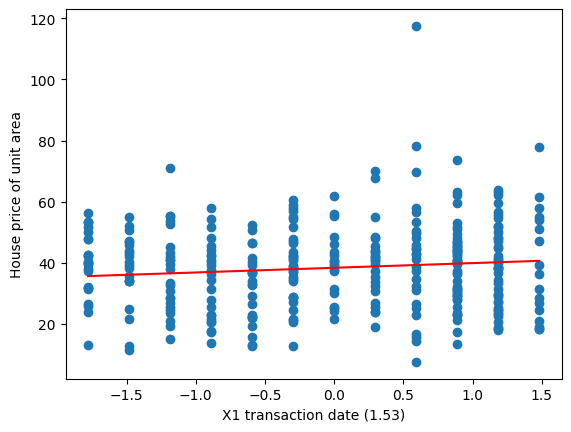

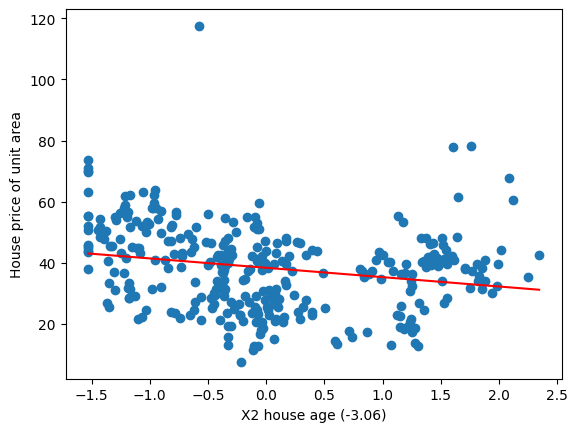

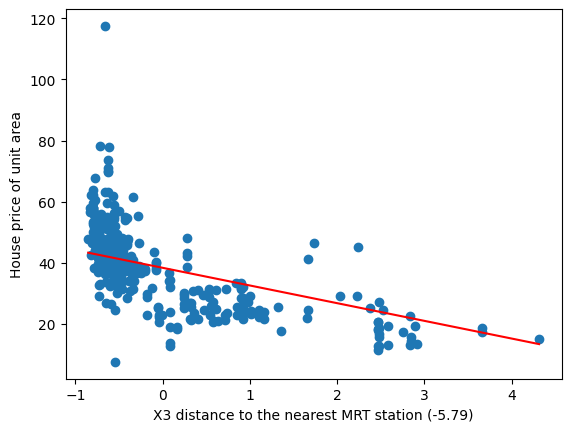

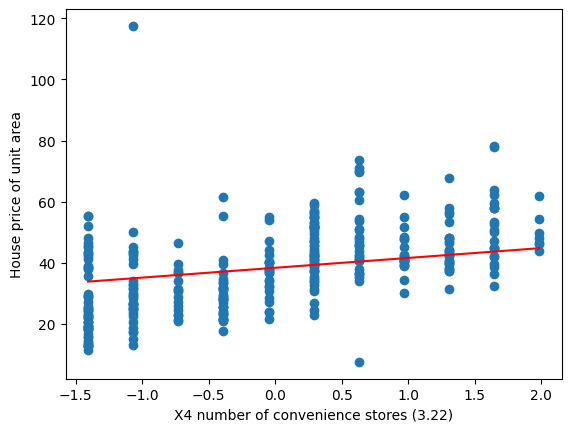

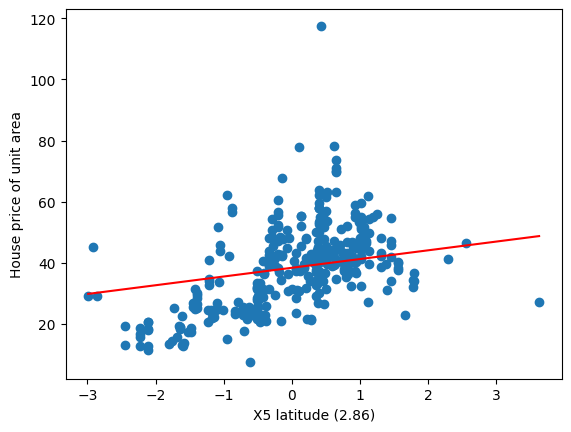

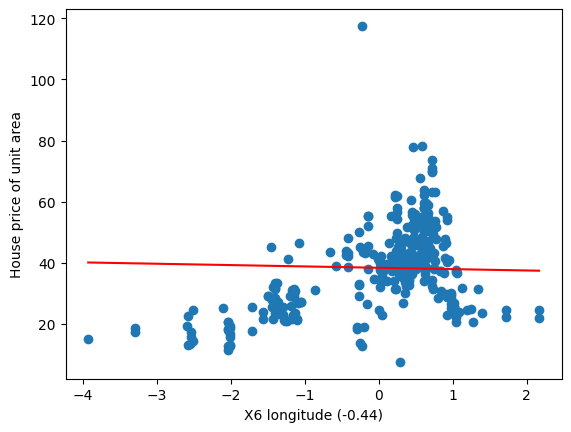

In [6]:
from matplotlib import pyplot as plt
i = 0
for feature in X_train.columns:
    plt.scatter(X_train[feature], y_train)
    xs = np.linspace(min(X_train[feature]), max(X_train[feature]))
    ys = beta0 + beta1[0][i] * xs
    plt.plot(xs, ys, color='red')
    plt.xlabel(f"{feature} ({beta1[0][i]:.2f})")
    plt.ylabel('House price of unit area')
    plt.show()
    i += 1

Yllä olevista graafeista, sekä niiden kertoimista, näemme mitkä arvot korreloivat positiivisesti ja negatiivisesti. Voimme tulla johtopäätökseen, että talon hintaan per ping vaikuttaa eniten etäisyys metroasemasta (X3), joka korreloi vahvasti negatiivisesti. Toisiksi eniten hintaan vaikuttaa talon lähellä olevien kauppojen määrä (X4), joka korreloi positiivesti. Kolmas suuresti vaikuttava tekijä on talon ikä (X2), joka korreloi myös negatiivisesti.

In [7]:
from sklearn.metrics import mean_absolute_error
preds = lin.predict(X_test)
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, preds))

Mean absolute error: 5.74


Saimme keskipoikkeamaksi 5.74, joka tarkoittaa ennustusten poikkeavan keskimäärin 5.74:n verran oikeasta tuloksesta. 5.74 vastaisi noin 60 000$/Ping.

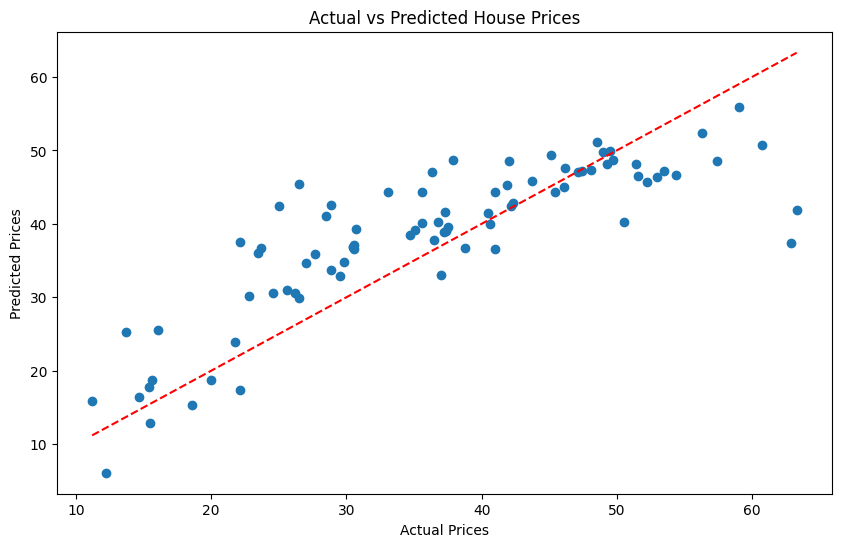

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.show()

Tästä graafista näemme, miten oikein ennustukset menivät. Jos ennustukset menisivät täydellisesti, kaikki pallot olisivat punaisella viivalla. Pallot jotka menevät katkoviivan yli tarkoittavat ennustuksen olevan yli oikean arvon, jos pallo on taas viivan alapuolella, ennustus on ollut liian pieni.

Luomme nyt uudet y_train ja y_test muuttujat, jotta voimme käyttää logistista regressiomallia ennustamaan binäärisen arvon. Binääriarvo on valittu siten, että jos hinta on yli keskiarvon, se merkataan 1:ksi, muuten se on 0.

In [9]:
y_train_bin = np.where(y_train > y_train.mean(), 1, 0).ravel()
y_train_bin.astype('int')
y_test_bin = np.where(y_test > y_test.mean(), 1, 0).ravel()
y_test_bin.astype('int')

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0])

### Logistinen regressio

In [10]:
# logistic regression
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(solver='lbfgs')
log.fit(X_train, y_train_bin)

LogisticRegression()

Accuracy: 0.87
Confusion Matrix:
 [[31  9]
 [ 2 41]]


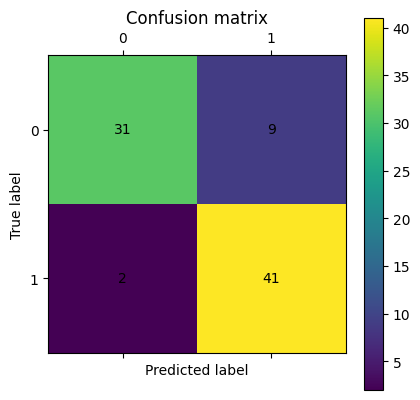

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(estimator=log, X=X_test, y=y_test_bin, cv=10)

cm = confusion_matrix(y_test_bin, y_pred)
accuracy = accuracy_score(y_test_bin, y_pred)

print("Accuracy: %0.2f" % accuracy)
print("Confusion Matrix:\n", cm)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# include counts
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

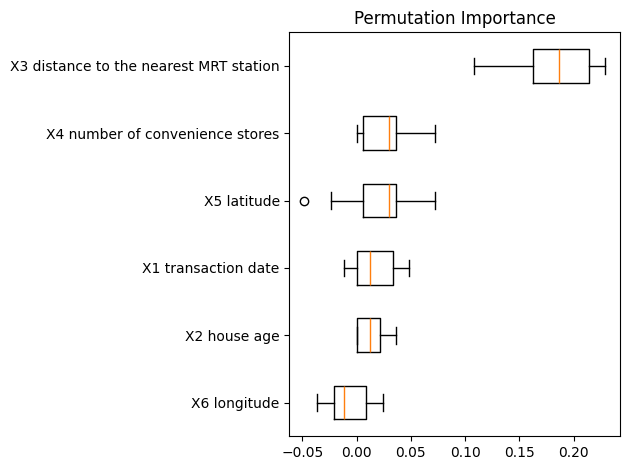

In [12]:
from sklearn.inspection import permutation_importance

result = permutation_importance(log, X_test, y_test_bin, n_repeats=10, scoring="accuracy", random_state=0, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

Voimme tehdä permutaatiokaaviosta samanlaisen johtopäätöksen, kuin lineaarisen regressiomallin kaavioista. Tärkein arvo asunnon hinnan kannalta on metroaseman läheisyys (X3), toiseksi tärkein on kauppojen läheisyys (X4). Päättelimme lineaarisen mallin perusteella kolmanneksi tärkeimmän arvon olevan talon ikä, mutta tässä tämän graafin mukaan se on vähemmän relevantti kuin leveysaste. 

## Arviointi
Molempien regressiomallien perusteella voimme tulla tulokseen, että metroaseman läheisyys (X3) on kaikista arvoista tärkein. Toisiksi tärkein arvo on kauppojen läheisyys (X4). Mallit antoivat näiden arvojen jälkeen erilaisia tuloksia, mutta tämä voi johtua muiden arvojen korrelaation samanlaisuudesta.

Testasimme molempia malleja ilman datan standardisointia, joka tuotti hyvin erilaisia kertoimia. Ilman standardisointia talojen leveysarvojen kertoimet olivat muita paljon tärkeämpiä. Lineaarinen malli tuotti silti ei-standardisoiduilla arvoilla hieman paremman keskipoikkeaman. 

## Käyttöönotto
Ennustukset voisivat olla hyödyllisiä esimerkiksi kiinteistövälittäjille tai ihmisille, jotka haluavat myydä omia kiinteistöjä. Datasetti perustuu juuri New Taipei Cityyn, joten ennustukset pätevät tarkasti ainoastaan tähän kaupunkiin. Ennustuksille tarvittaisiin luultavasti oma sovellus tai nettisivu, joka tarjoisi käyttäjälle helpon käyttäjäkokemuksen. Jos sovellusta haluttaisiin laajentaa, tarvittaisiin lisää dataa eri kaupungeille.